In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train Phase transformations

albu_transforms = A.Compose([ #modified this slightly
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),  # Padding by 4
    A.RandomCrop(32, 32),  # Random Crop to 32x32
    A.HorizontalFlip(p=0.5),  # FlipLR - Horizontal flip
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=(0, 0, 0), p=0.5),  # CutOut
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
])

def albu_transform(image):
    # Convert PIL image to numpy array
    image_np = np.array(image)
    # Apply Albumentations transforms
    transformed = albu_transforms(image=image_np)
    return transformed['image']

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [ ]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=albu_transform)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 46971681.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


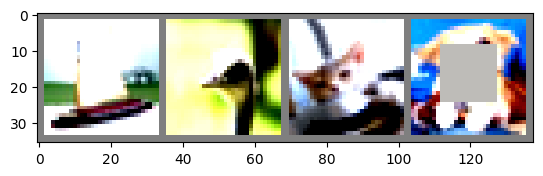

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# !pip install torchsummary

In [ ]:
import torch.nn.functional as F
from torchsummary import summary

dropout_value = 0.02
group_value = 4
class CustomResNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
        self.conv1 = nn.Sequential(  #input_size = 32
            nn.Conv2d(3, 128, 3, padding=1, stride = 1, bias=False), #kernel_is: 3x3
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        # R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
        self.r1 = nn.Sequential( #16
            nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ) #16
        # Conv 3x3 [256k] Layer2
        self.conv2 = nn.Sequential( #16
            nn.Conv2d(128, 256, 3, padding = 1, stride = 1, bias = False),
            nn.MaxPool2d(2,2)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        ) #8
        # X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1, stride = 1, bias=False), #kernel_is: 3x3
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        ) #4
        # R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
        self.r2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        #MaxPooling with Kernel Size 4
        self.pool1 = nn.MaxPool2d(4, 4) #input_size = 4, #output_size = 1 (after maxpool with 4x4)
        #FC layer
        self.fc1 = nn.Linear(in_features=512*1 * 1, out_features=10) #cifar10, so 10




    def forward(self, x):
        x = self.conv1(x)
        r1 = self.r1(x)
        x = x + r1
        x = self.conv2(x)
        x = self.conv3(x)
        r2 = self.r2(x)
        x = x + r2
        x = self.pool1(x)
        print("After pool, ", x.shape)
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]             576
            Conv2d-5          [-1, 128, 32, 32]           8,192
              ReLU-6          [-1, 128, 32, 32]               0
       BatchNorm2d-7          [-1, 128, 32, 32]             256
            Conv2d-8           [-1, 64, 16, 16]          73,728
            Conv2d-9           [-1, 64, 16, 16]             576
           Conv2d-10          [-1, 128, 16, 16]           8,192
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13          [-1, 128, 16, 16]           1,152
           Conv2d-14          [-1,

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion): #adding scheduler and criterion
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    # loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))                           #adding extra line

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()                                        #adding extra line

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

                                                            #adding get_lr function below
    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, criterion):            #added criterion here
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []  # List to store misclassified images and labels
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim = True)  # Remove keepdim=True; now shape: [batch_size]
            correct += pred.eq(target.view_as(pred)).sum().item()        #modified this line

            # Find misclassified indices
            misclassified_idxs = (pred != target).nonzero(as_tuple=False).squeeze()
            for idx in misclassified_idxs:
                if len(misclassified_images) < 10:  # Collect only 10 images
                    img = data[idx].cpu()
                    actual_label = target[idx].item()
                    predicted_label = pred[idx].item()
                    misclassified_images.append((img, predicted_label, actual_label))
                else:
                    break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, Accuracy

In [ ]:
#adding new code
from torch_lr_finder import LRFinder

model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # this should give u the lr to feed in OneCyclePolicy

In [ ]:
from torch.optim.lr_scheduler improt OneCycleLR
EPOCHS = 24
scheduler = OneCycleLR(
    optimizer, #defined above
    max_lr = ... , #u'll get above
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100 , #defining min_lr
    three_phase = False, #no Annihilation
    final_div_factor = 100 , #again in support of min_lr
    anneal_strategry = 'linear'
)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion) #adding criterion as argument
    test(model, device, test_loader, criterion)                                #modified train and test function

In [ ]:
# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# # scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, 'max', patience = 20)


# EPOCHS = 50
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer, epoch)
#     # scheduler.step()
#     # test(model, device, test_loader)
#     misclassified_images, Accuracy = test(model, device, test_loader)
#     scheduler.step(Accuracy)

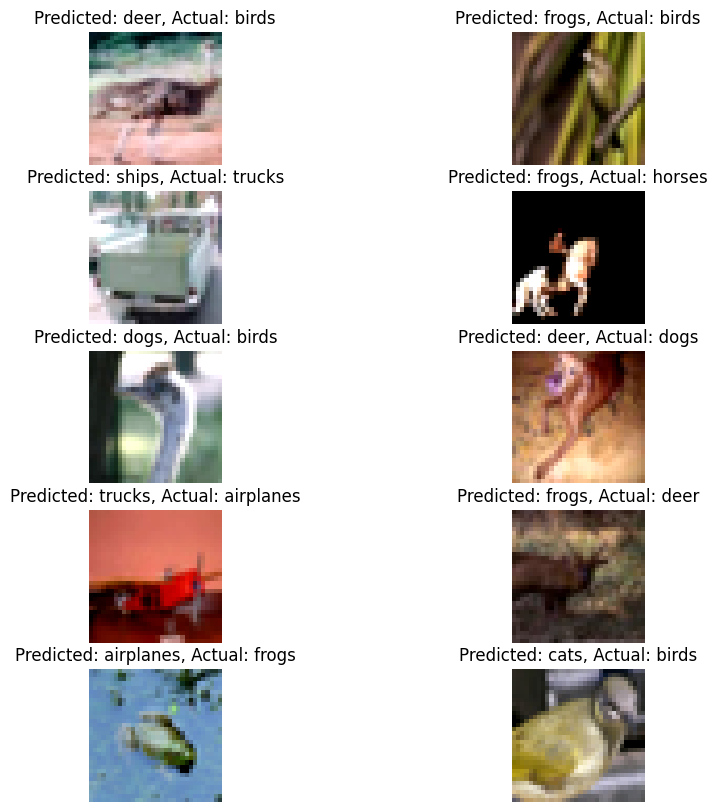

In [ ]:
import matplotlib.pyplot as plt

def visualize_misclassified_images(misclassified_images):
    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    plt.figure(figsize=(10, 10)) #original images were 32x32
    for i, (image, pred, actual) in enumerate(misclassified_images[:10]):
        image = image.numpy().transpose(1, 2, 0)  # Convert to (height, width, channel)
        mean = [0.4914, 0.4822, 0.4465] #3 values for 2 channels, RGB
        std = [0.247, 0.243, 0.261]
        image = image * std + mean  # Undo normalization
        image = np.clip(image, 0, 1)  # Clip values to valid range

        plt.subplot(5, 2, i+1)
        plt.imshow(image)

        plt.title(f"Predicted: {classes[pred]}, Actual: {classes[actual]}")
        plt.axis('off')
    plt.show()

visualize_misclassified_images(misclassified_images)


In [ ]:
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
t = [train_items.item() for train_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

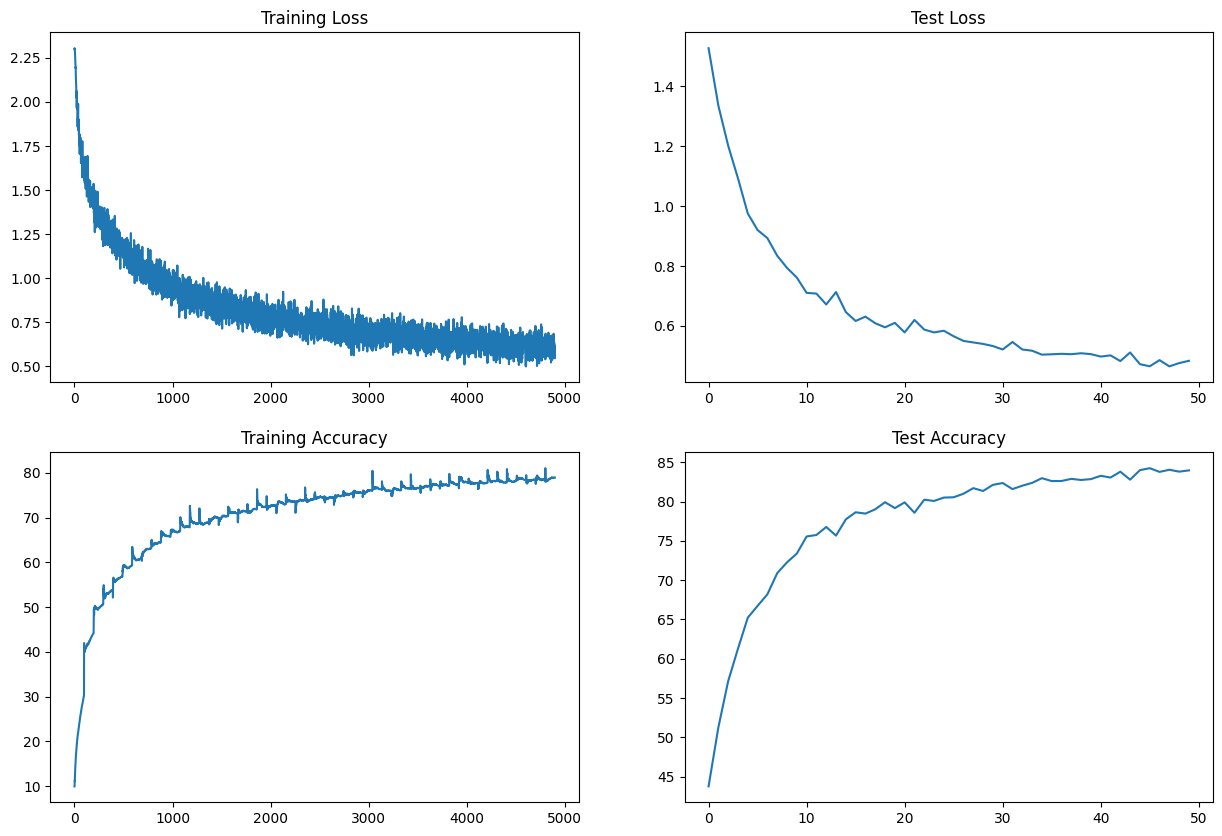

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers


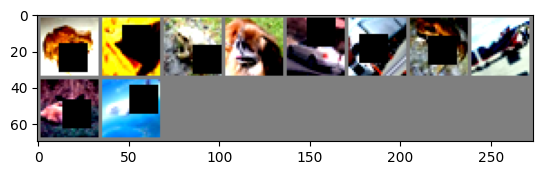

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

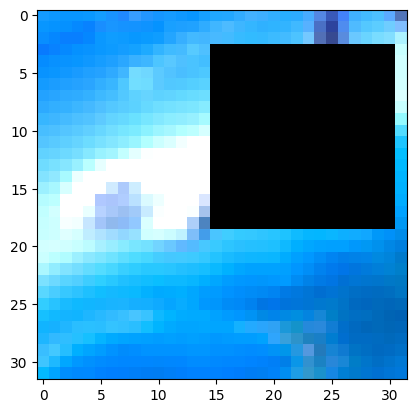

In [ ]:
image = images[9]
imshow(image)

In [ ]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

10
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 36, 36])
torch.Size([1, 64, 36, 36])
torch.Size([1, 64, 36, 36])
torch.Size([1, 32, 40, 40])
torch.Size([1, 64, 40, 40])
torch.Size([1, 64, 40, 40])
torch.Size([1, 32, 44, 44])
torch.Size([1, 10, 44, 44])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(36, 36)
(36, 36)
(36, 36)
(40, 40)
(40, 40)
(40, 40)
(44, 44)
(44, 44)


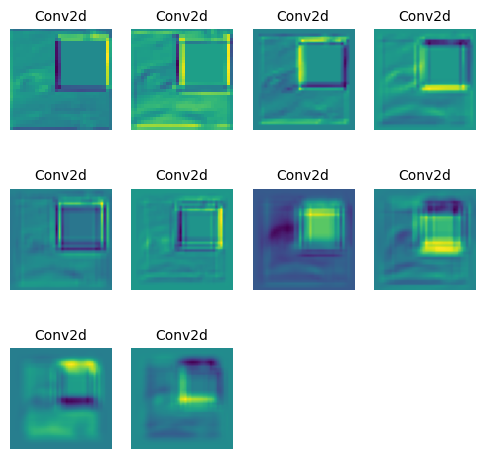

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

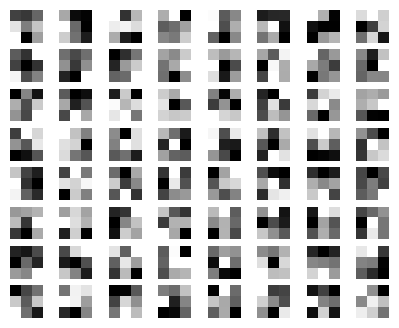

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

# Sess11 Attempt

In [ ]:
#doing a git clne situation
!git clone 'https://github.com/shilpiprd/ERA-Solution.git'

Cloning into 'ERA-Solution'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 188 (delta 70), reused 163 (delta 45), pack-reused 0
Receiving objects: 100% (188/188), 33.77 MiB | 24.13 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [ ]:
%cd ERA-Solution/Sess11\ Solution/

/content/ERA-Solution/Sess11 Solution


In [ ]:
ls

his_S11.ipynb  main.py  my_main.py   pytorch_grad_cam/  utils.py
his_utils.py   models/  my_utils.py  run.ipynb


In [ ]:
from models.resnet import ResNet18
import torch

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18()
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

100%|██████████| 170498071/170498071 [00:04<00:00, 42422449.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


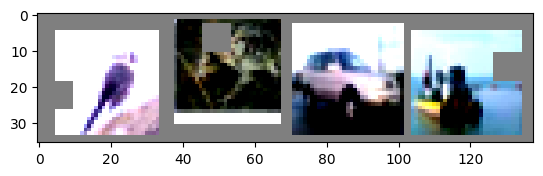

bird  frog  car   ship 


In [ ]:
#wanna visualize ur data ?
from my_main import visualize_train_data
visualize_train_data()

In [ ]:
!pip install torch_lr_finder

Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.65E-02


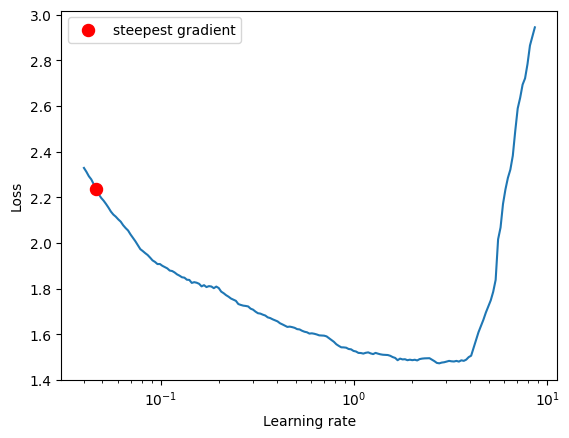

In [ ]:
#adding new code
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_lr_finder import LRFinder
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
#importing train_loader from one
from my_main import train_loader
from my_main import classes, test_loader
# from datasets import AlbumDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from augmentations import train_set_transforms, test_set_transforms
from torchvision import datasets, transforms


#defining my own train_loader
# hey_transform = A.Compose([
#     'randomcrop': A.RandomCrop(height=32, width=32, p=1),
#     'horizontalflip': A.HorizontalFlip(p=1),
#     'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
#     'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
#     'standardize': ToTensorV2(),
# ])

hey_transform = A.Compose([ #modified this slightly
                             A.RandomCrop(height=32, width=32, p=1),
                              A.HorizontalFlip(p=1),
                              A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
                              A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
                              ToTensorV2(),
])

def hey_transform_func(image):
    # Convert PIL image to numpy array
    image_np = np.array(image)
    # Apply Albumentations transforms
    transformed = hey_transform(image=image_np)
    return transformed['image']


train_set = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=hey_transform_func)
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

#<-----using albumentations completely ---------->
# my_other_transform = A.Compose(hey_transform.values())
# train_set = AlbumDataset('./data', train=True, download=True, transform=my_other_transform)
# my_train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
# <------------------------------------------------------------->
#his way of finding lr
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
my_optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()
lr_finder2 = LRFinder(model, my_optimizer, criterion, device='cuda')
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [ ]:
x =   #deliberate error

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 20

my_scheduler = torch.optim.lr_scheduler.OneCycleLR(my_optimizer, #6.60E-02 , his_value:6.79E-02
                                                max_lr= 4.65E-02,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

In [ ]:
#define the train and test function here
# from my_main import train, test
from my_main import test_loader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from my_main import test

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion): #adding scheduler and criterion
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))                           #adding extra line

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()                                        #adding extra line

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

                                                            #adding get_lr function below
    pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    return train_acc, train_losses

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc, train_loss = train(model, device, train_loader, my_optimizer, epoch, my_scheduler, criterion)
    # train_acc, train_loss = train(model = model, device = device,optimizer=my_optimizer,scheduler = my_scheduler)
    test_acc, test_loss, misclassified = test(model, device, test_loader, criterion) #default values are good                              #modified train and test function

EPOCH: 0


Loss=2.428011417388916 LR=0.0005434241908006814 Batch_id=0 Accuracy=11.52:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1049/10000 (10.49%)

EPOCH: 1


Loss=2.4667699337005615 LR=0.0006218483816013629 Batch_id=0 Accuracy=9.38:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 842/10000 (8.42%)

EPOCH: 2


Loss=2.468641519546509 LR=0.0007002725724020442 Batch_id=0 Accuracy=9.96:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1011/10000 (10.11%)

EPOCH: 3


Loss=2.4281296730041504 LR=0.0007786967632027257 Batch_id=0 Accuracy=9.77:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1004/10000 (10.04%)

EPOCH: 4


Loss=2.4190237522125244 LR=0.0008571209540034071 Batch_id=0 Accuracy=10.55:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=2.3472743034362793 LR=0.0009355451448040885 Batch_id=0 Accuracy=11.33:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=2.3513917922973633 LR=0.00101396933560477 Batch_id=0 Accuracy=8.98:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=2.3417186737060547 LR=0.0010923935264054514 Batch_id=0 Accuracy=14.06:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=2.2673985958099365 LR=0.0011708177172061328 Batch_id=0 Accuracy=13.48:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=2.2738358974456787 LR=0.0012492419080068142 Batch_id=0 Accuracy=15.23:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=2.2377376556396484 LR=0.0013276660988074957 Batch_id=0 Accuracy=18.36:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=2.2491281032562256 LR=0.001406090289608177 Batch_id=0 Accuracy=16.60:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1011/10000 (10.11%)

EPOCH: 12


Loss=2.2305846214294434 LR=0.0014845144804088585 Batch_id=0 Accuracy=18.55:   0%|          | 0/98 [00:01<?, ?it/s]



Test set: Average loss: 0.0046, Accuracy: 1307/10000 (13.07%)

EPOCH: 13


Loss=2.2547311782836914 LR=0.00156293867120954 Batch_id=0 Accuracy=17.38:   0%|          | 0/98 [00:01<?, ?it/s]


KeyboardInterrupt: 

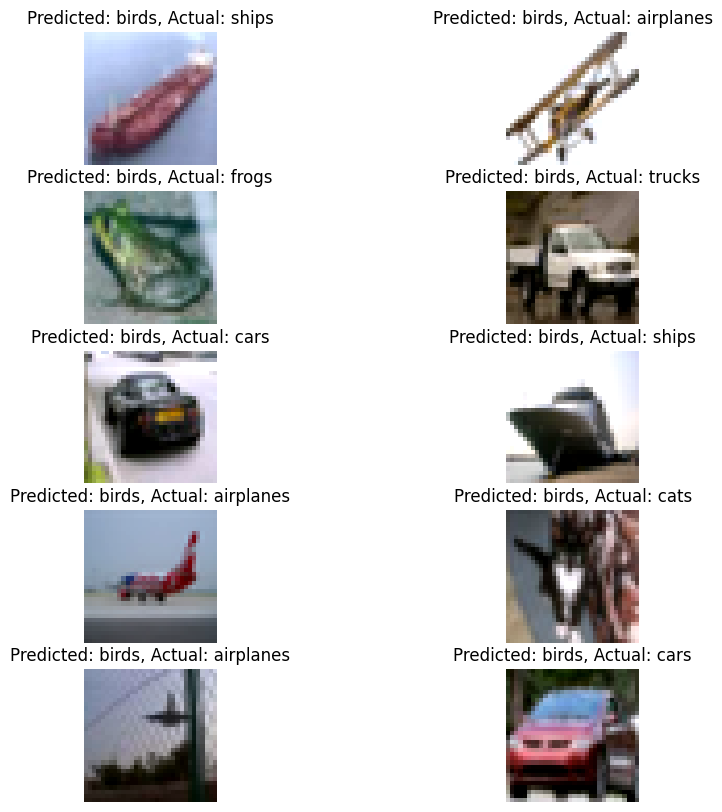

In [ ]:
from my_utils import visualize_misclassified_images
visualize_misclassified_images(misclassified)

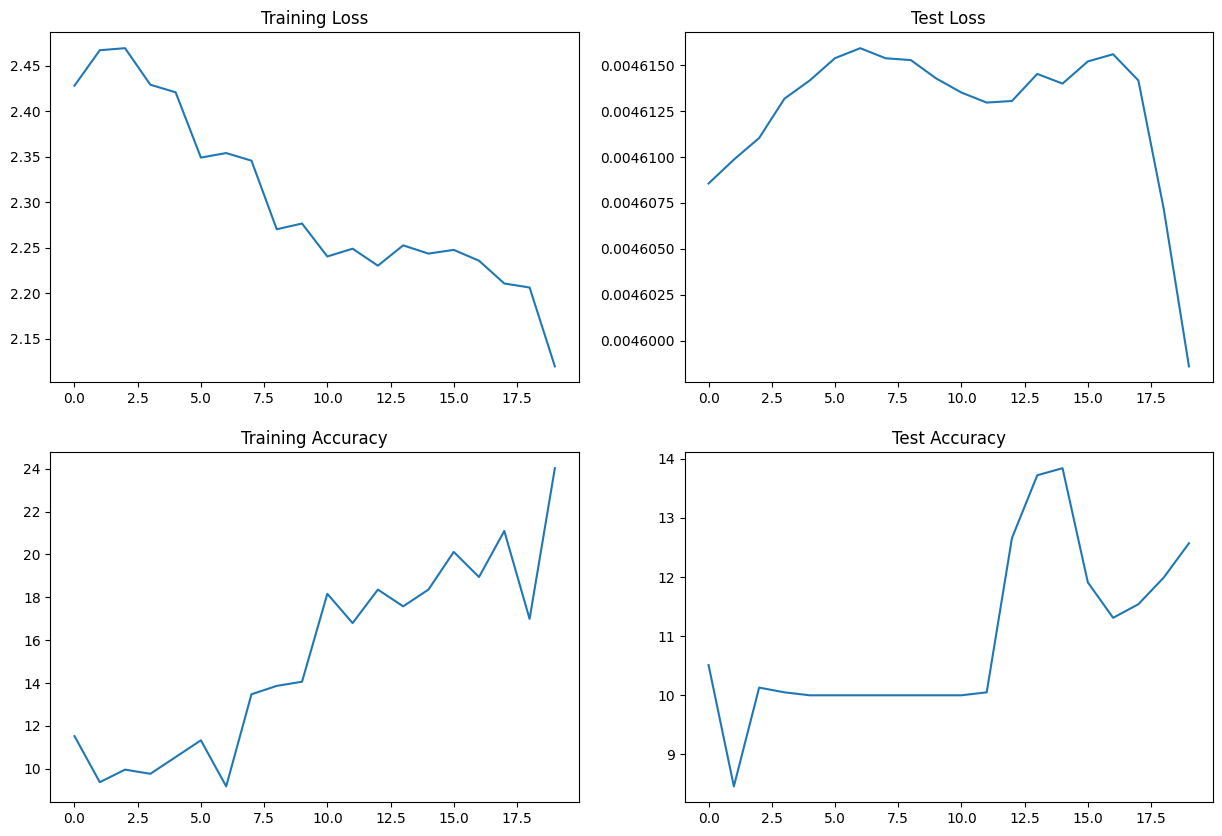

In [ ]:
from my_utils import visualize_loss_accuracy
from torchvision import transforms
import math
visualize_loss_accuracy(train_loss,train_acc, test_loss, test_acc) #fixed test_loss thing

In [ ]:
!pip install ttach

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
# from models.resnet import ResNet18
import matplotlib.pyplot as plt

In [ ]:
#applying gradcam on a single image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

idx = 4 #taking the 4th image which should be trucks predicted as birds
target_layers = [model.layer4[-1]]
input_tensor = misclassified[idx][0].unsqueeze(0).to(next(model.parameters()).device)# Create an input tensor image for your model..
# print(input_tensor) #has some value >1
cam = GradCAM(model=model, target_layers=target_layers)

# targets = [ClassifierOutputTarget(misclassified[idx][1])]
targets = None
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
# Get back the original image
rgb_img = input_tensor.squeeze(0).to('cpu')
rgb_img = inv_normalize(rgb_img)
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.7)

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(visualization)

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-56-13304e4bb0e0>:65: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


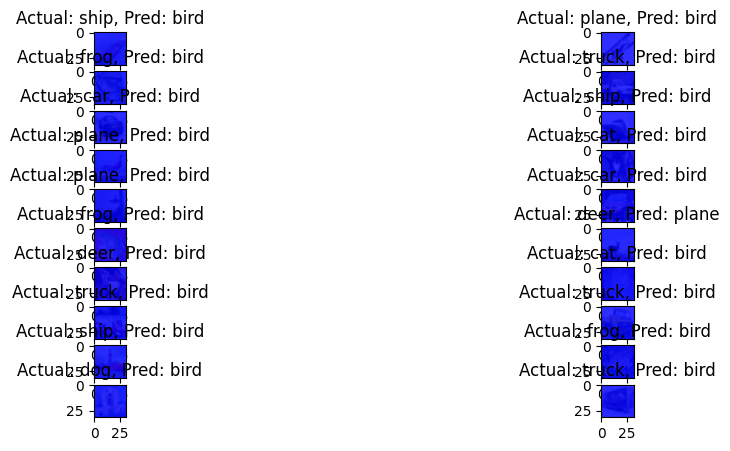

In [ ]:
#attempt to implement gradcam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from sklearn import preprocessing

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = None # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

cam = GradCAM(model=model, target_layers=target_layers) #cuda is a boolean variable
# targets = [ClassifierOutputTarget(281)]
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
#you've misclassified : image, actual, pred
# Iterate over number of specified images
# data = [(img, actual_label) for img, actual_label, _ in misclassified]

data = misclassified

number_of_samples = 20
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23]
std=[1/0.23, 1/0.23, 1/0.23]
fig = plt.figure(figsize=(12, 5))
for i in range(number_of_samples): #i'm guessing number of samples is 20
    sub = fig.add_subplot(10,2, i + 1) #randomly setting values
    input_tensor = data[i][0]
    # print('this is input_tensor : ', input_tensor.shape) #(3, 32, 32)
    # Get the activations of the layer for the images
    #unsqueze image and send it to same device asmodel
    input_tensor = input_tensor.unsqueeze(0).to(next(model.parameters()).device)
    # print('now, shape is: ', input_tensor.shape)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Get back the original image
    img = input_tensor.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img.numpy(), (1, 2, 0))
    # rgb_img = rgb_img.numpy()
    rgb_img = np.clip(rgb_img, 0, 1)
    # print('rgb_img: ', np.max(rgb_img))
    # Mix the activations on the original image
    # rgb_img = (rgb_img - mean)/std
    # print('rgb_img: ', np.max(rgb_img))
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.1)
    # visualization = show_cam_on_image(unnormalize(misclassified[i].cpu()), grayscale_cam, use_rgb=True, image_weight = 0.7)
    # Display the images on the plot
    plt.imshow(visualization)
    # plt.title(r"Correct: " + classes[data[i][1].item()] + '\n' + 'Output: ' + classes[data[i][2].item()])
    sub.set_title("Actual: {}, Pred: {}".format(classes[data[i][1]], classes[data[i][2]],color='red'))
    # plt.xticks([])
plt.tight_layout()
plt.show()
    #<------------He just uses: ------------------------------------>
    # visualization = show_cam_on_image(unnormalize(images[idx].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)
    # fig, ax = plt.subplots(figsize=(2, 2))
    # ax.imshow(visualization)
    #<------------------------------------------------------------->


In [ ]:
#DO NOT RUN THIS
#apply gradcam on misclassified images

def display_gradcam_output(data: list,
                           classes: list[str],
                           target_layers, #not specifying default value
                           inv_normalize: transforms.Normalize,
                           model: model,
                        #    target_layers: list['model_layer'],
                           targets=None,
                           number_of_samples: int = 10,
                           transparency: float = 0.60):
    """
    Function to visualize GradCam output on the data
    :param data: List[Tuple(image, label)]
    :param classes: Name of classes in the dataset
    :param inv_normalize: Mean and Standard deviation values of the dataset
    :param model: Model architecture
    :param target_layers: Layers on which GradCam should be executed
    :param targets: Classes to be focused on for GradCam
    :param number_of_samples: Number of images to print
    :param transparency: Weight of Normal image when mixed with activations
    """
    # Plot configuration
    fig = plt.figure(figsize=(10, 10))
    x_count = 5
    y_count = 1 if number_of_samples <= 5 else math.floor(number_of_samples / x_count)

    # Create an object for GradCam
    cam = GradCAM(model=model, target_layers=target_layers)

    # Iterate over number of specified images
    for i in range(number_of_samples):
        plt.subplot(y_count, x_count, i + 1)
        input_tensor = data[i][0]

        # Get the activations of the layer for the images
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Get back the original image
        img = input_tensor.squeeze(0).to('cpu')
        img = inv_normalize(img)
        rgb_img = np.transpose(img, (1, 2, 0))
        rgb_img = rgb_img.numpy()

        # Mix the activations on the original image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)

        # Display the images on the plot
        plt.imshow(visualization)
        plt.title(r"Correct: " + classes[data[i][1].item()] + '\n' + 'Output: ' + classes[data[i][2].item()])
        plt.xticks([])
        plt.yticks([])

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010]
)
target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None #means highest scoring category will be used for every image in the batch.

data_for_gradcam = [(img, actual) for img, actual, pred in misclassified]

display_gradcam_output(data=data_for_gradcam, classes=classes,target_layers=target_layers, inv_normalize=inv_normalize, model= model, targets= targets, number_of_samples=20, transparency=0.70)

# Starting from scratch for GradCam implementation

In [ ]:
!git clone 'https://github.com/shilpiprd/ERA-Solution.git'

Cloning into 'ERA-Solution'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 188 (delta 70), reused 163 (delta 45), pack-reused 0
Receiving objects: 100% (188/188), 33.77 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [ ]:
%cd ERA-Solution/Sess11\ Solution/

/content/ERA-Solution/Sess11 Solution


In [ ]:
!pip install torch_lr_finder

In [ ]:
!pip install ttach

In [ ]:
from models.resnet import ResNet18
import torch

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18()
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

100%|██████████| 170498071/170498071 [00:03<00:00, 44537736.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


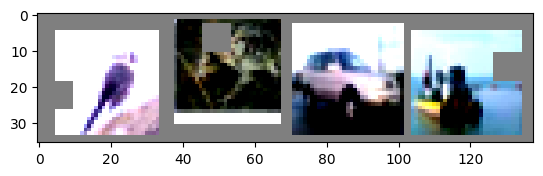

bird  frog  car   ship 


In [ ]:
#wanna visualize ur data ?
from my_main import visualize_train_data
visualize_train_data()

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.52E-03


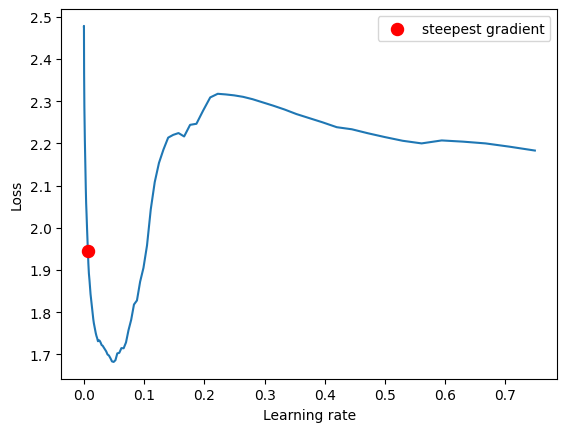

In [ ]:
from my_main import train_loader , test_loader, classes
#lr finder
import copy
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import numpy as np

net_exp = copy.deepcopy(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp.parameters(), lr=1e-3, momentum=0.85)
lr_finder = LRFinder(net_exp, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=1e-5, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset() #i should get 3. something

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
EPOCHS = 24
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr= 5.94E-01, #set this value
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=0.2,
                                                three_phase=False, #adding this on my own
                                                final_div_factor=100, #adding this on my own
                                                anneal_strategy='linear')


In [ ]:
# Training, github training and test loop
# def train(epoch):
from tqdm import tqdm
from my_utils import get_lr
def train(model, device, train_loader, optimizer, scheduler, criterion, epoch):
    model.train()
    pbar = tqdm(train_loader)  #adding
    train_loss = 0
    correct = 0
    total = 0
    train_acc = []     #adding
    train_losses = [] #adding
    processed = 0     #adding
    for batch_idx, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        train_losses.append(loss)  #adding
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    return train_acc, train_losses #train_loss is a scalar
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
# def test(epoch):
def test(model, device, test_loader, criterion):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    test_losses = [] #added
    test_acc = []    #added
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    # <-------------------------Adding-------------------------------------------->
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc, test_losses
    # <------------------------------------------------------------------------------>
    # Save checkpoint., dont wanna
    # acc = 100.*correct/total
    # if acc > best_acc:
    #     print('Saving..')
    #     state = {
    #         'model': model.state_dict(),
    #         'acc': acc,
    #         'epoch': epoch,
    #     }
    #     if not os.path.isdir('checkpoint'):
    #         os.mkdir('checkpoint')
    #     torch.save(state, './checkpoint/ckpt.pth')
    #     best_acc = acc



# for epoch in range(start_epoch, start_epoch+200):
#     train_acc, train_loss = train(epoch)
#     test_acc, test_loss = test(epoch) #used later for plotting
#     scheduler.step()

In [ ]:
EPOCHS= 24

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(model, device, batch, optimizer, criterion, epoch)
  print('EPOCH: ', epoch)
  train_acc, train_loss = train(model, device, train_loader, optimizer, scheduler, criterion, epoch)
  test_acc, test_loss = test(model, device, test_loader, criterion)

print('Finished Training')

EPOCH:  0


Loss=1.4021859169006348 LR=0.02376 Batch_id=97 Accuracy=39.04: 100%|██████████| 98/98 [00:37<00:00,  2.63it/s]



Test set: Average loss: 0.0030, Accuracy: 4836/10000 (48.36%)

EPOCH:  1


Loss=1.087956428527832 LR=0.02376 Batch_id=97 Accuracy=56.23: 100%|██████████| 98/98 [00:38<00:00,  2.58it/s]



Test set: Average loss: 0.0027, Accuracy: 5538/10000 (55.38%)

EPOCH:  2


Loss=0.8742228150367737 LR=0.02376 Batch_id=97 Accuracy=66.60: 100%|██████████| 98/98 [00:38<00:00,  2.56it/s]



Test set: Average loss: 0.0019, Accuracy: 6632/10000 (66.32%)

EPOCH:  3


Loss=0.7332280874252319 LR=0.02376 Batch_id=97 Accuracy=72.09: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]



Test set: Average loss: 0.0017, Accuracy: 7248/10000 (72.48%)

EPOCH:  4


Loss=0.6148668527603149 LR=0.02376 Batch_id=97 Accuracy=76.70: 100%|██████████| 98/98 [00:38<00:00,  2.56it/s]



Test set: Average loss: 0.0014, Accuracy: 7596/10000 (75.96%)

EPOCH:  5


Loss=0.6285154223442078 LR=0.02376 Batch_id=97 Accuracy=79.45: 100%|██████████| 98/98 [00:38<00:00,  2.55it/s]



Test set: Average loss: 0.0015, Accuracy: 7545/10000 (75.45%)

EPOCH:  6


Loss=0.6081359386444092 LR=0.02376 Batch_id=97 Accuracy=81.62: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]



Test set: Average loss: 0.0013, Accuracy: 7828/10000 (78.28%)

EPOCH:  7


Loss=0.4923345148563385 LR=0.02376 Batch_id=97 Accuracy=82.95: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]



Test set: Average loss: 0.0014, Accuracy: 7802/10000 (78.02%)

EPOCH:  8


Loss=0.5066555738449097 LR=0.02376 Batch_id=97 Accuracy=84.28: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]



Test set: Average loss: 0.0013, Accuracy: 7883/10000 (78.83%)

EPOCH:  9


Loss=0.36369359493255615 LR=0.02376 Batch_id=97 Accuracy=85.68: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]



Test set: Average loss: 0.0011, Accuracy: 8314/10000 (83.14%)

EPOCH:  10


Loss=0.416227251291275 LR=0.02376 Batch_id=97 Accuracy=86.65: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]



Test set: Average loss: 0.0012, Accuracy: 8104/10000 (81.04%)

EPOCH:  11


Loss=0.3980553448200226 LR=0.02376 Batch_id=97 Accuracy=87.93: 100%|██████████| 98/98 [00:38<00:00,  2.54it/s]



Test set: Average loss: 0.0010, Accuracy: 8347/10000 (83.47%)

EPOCH:  12


Loss=0.26822683215141296 LR=0.02376 Batch_id=97 Accuracy=88.52: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]



Test set: Average loss: 0.0011, Accuracy: 8211/10000 (82.11%)

EPOCH:  13


Loss=0.3203665018081665 LR=0.02376 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]



Test set: Average loss: 0.0011, Accuracy: 8238/10000 (82.38%)

EPOCH:  14


Loss=0.21818816661834717 LR=0.02376 Batch_id=97 Accuracy=90.01: 100%|██████████| 98/98 [00:38<00:00,  2.52it/s]



Test set: Average loss: 0.0010, Accuracy: 8476/10000 (84.76%)

EPOCH:  15


Loss=0.34228235483169556 LR=0.02376 Batch_id=97 Accuracy=90.29: 100%|██████████| 98/98 [00:39<00:00,  2.46it/s]



Test set: Average loss: 0.0009, Accuracy: 8626/10000 (86.26%)

EPOCH:  16


Loss=0.20584090054035187 LR=0.02376 Batch_id=97 Accuracy=90.80: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]



Test set: Average loss: 0.0009, Accuracy: 8651/10000 (86.51%)

EPOCH:  17


Loss=0.39005589485168457 LR=0.02376 Batch_id=97 Accuracy=91.47: 100%|██████████| 98/98 [00:39<00:00,  2.49it/s]



Test set: Average loss: 0.0009, Accuracy: 8684/10000 (86.84%)

EPOCH:  18


Loss=0.26994773745536804 LR=0.02376 Batch_id=97 Accuracy=91.85: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]



Test set: Average loss: 0.0007, Accuracy: 8835/10000 (88.35%)

EPOCH:  19


Loss=0.22391682863235474 LR=0.02376 Batch_id=97 Accuracy=92.28: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]



Test set: Average loss: 0.0009, Accuracy: 8676/10000 (86.76%)

EPOCH:  20


Loss=0.21283890306949615 LR=0.02376 Batch_id=97 Accuracy=92.50: 100%|██████████| 98/98 [00:38<00:00,  2.53it/s]



Test set: Average loss: 0.0009, Accuracy: 8648/10000 (86.48%)

EPOCH:  21


Loss=0.23886163532733917 LR=0.02376 Batch_id=97 Accuracy=93.17: 100%|██████████| 98/98 [00:39<00:00,  2.51it/s]



Test set: Average loss: 0.0008, Accuracy: 8840/10000 (88.40%)

EPOCH:  22


Loss=0.225998654961586 LR=0.02376 Batch_id=97 Accuracy=93.47: 100%|██████████| 98/98 [00:39<00:00,  2.50it/s]



Test set: Average loss: 0.0008, Accuracy: 8898/10000 (88.98%)

EPOCH:  23


Loss=0.2654079794883728 LR=0.02376 Batch_id=97 Accuracy=93.63: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]



Test set: Average loss: 0.0007, Accuracy: 8869/10000 (88.69%)

Finished Training


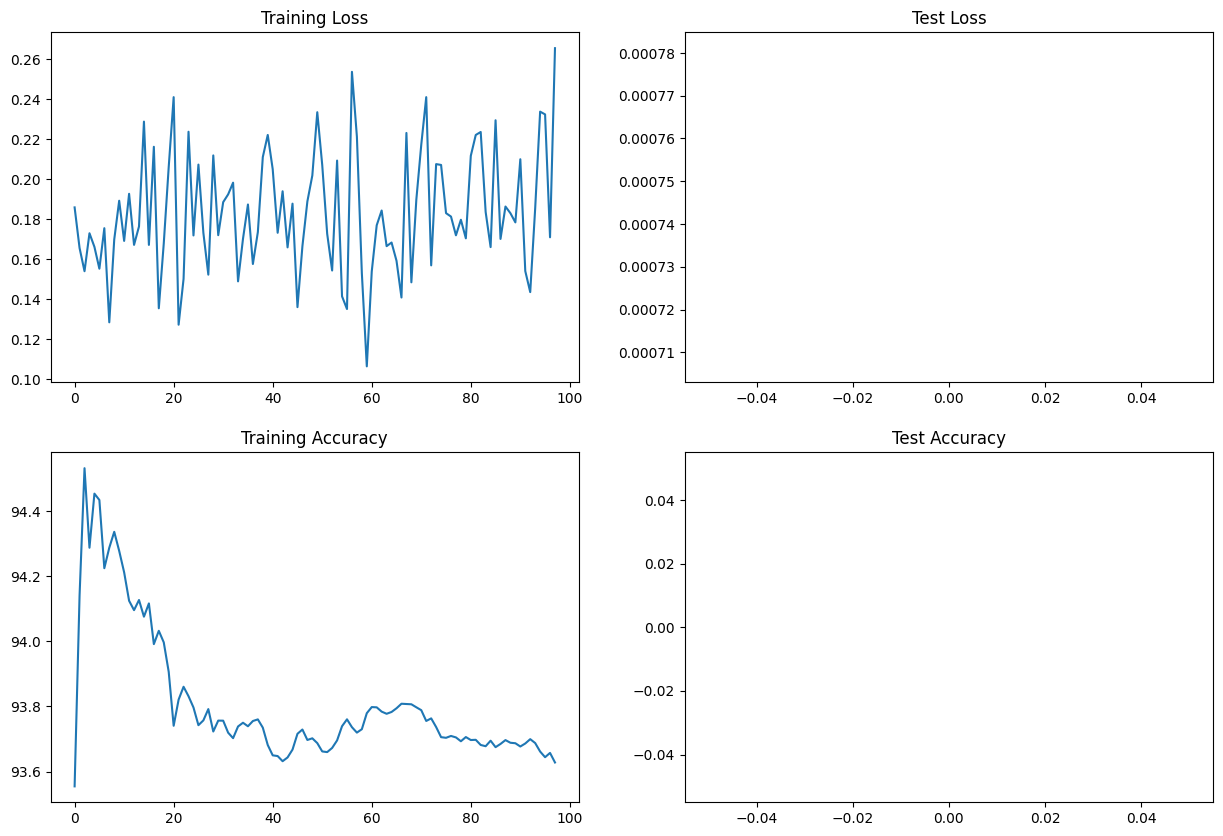

In [ ]:
#visualize the trianing and test loss :
from my_utils import visualize_loss_accuracy
from torchvision import transforms
import math
visualize_loss_accuracy(train_loss,train_acc, test_loss, test_acc)

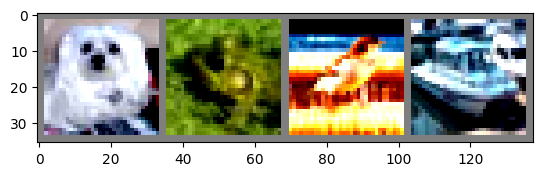

dog   frog  bird  ship 


In [ ]:
#display an image from test set
# images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)
import torchvision
import matplotlib.pyplot as plt
from my_main import test_loader

def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(test_loader)
images, labels = next(dataiter)
# images,labels = images.to(device),labels.to(device)
imshow(torchvision.utils.make_grid(images[:4])) #deciding to take 4 pictures
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
x = #deliberate error

torch.Size([512, 3, 32, 32])


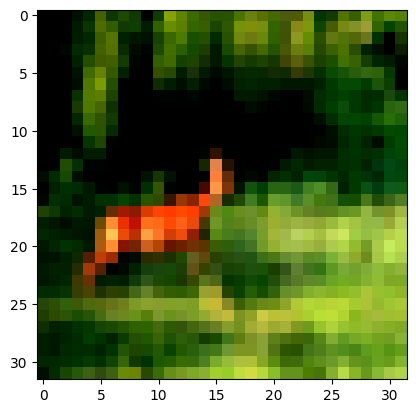

tensor([4], device='cuda:0')
deer


In [ ]:
#if images is a list of all images ,
print(images.shape)
imshow(images[4])
label_pred = model(images[4].unsqueeze(0).to(device))
label_idx = torch.argmax(label_pred, dim=1)
print(label_idx)
print(classes[label_idx])

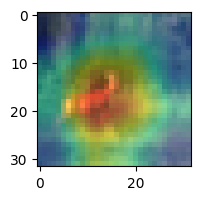

In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

idx = 4 #choosing the 4th image from test dataset, and applying cam on it
# model = net
target_layers = [model.layer4[-1]]
input_tensor = images[idx].unsqueeze(dim=0)# Create an input tensor image for your model..
cam = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(labels[idx])]
targets = None
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
# inv_normalize = transforms.Normalize(
#     mean=[0.4914, 0.4822, 0.4465],
#     std=[0.2023, 0.1994, 0.2010]
# )
# img = input_tensor.squeeze(0).to('cpu')
# img = inv_normalize(img)
# rgb_img = np.transpose(img, (1, 2, 0))
# rgb_img = rgb_img.numpy()
# <-------------------------------------------------------->
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

img = input_tensor.squeeze(0).to('cpu').numpy()
img = np.transpose(img, (1, 2, 0))  # Convert to numpy and reshape to HxWxC
img = std * img + mean
img = np.clip(img, 0, 1)
# <---------------------------------------------------------->
# visualization = show_cam_on_image(unnormalize(images[idx].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, image_weight=0.7)

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(visualization)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


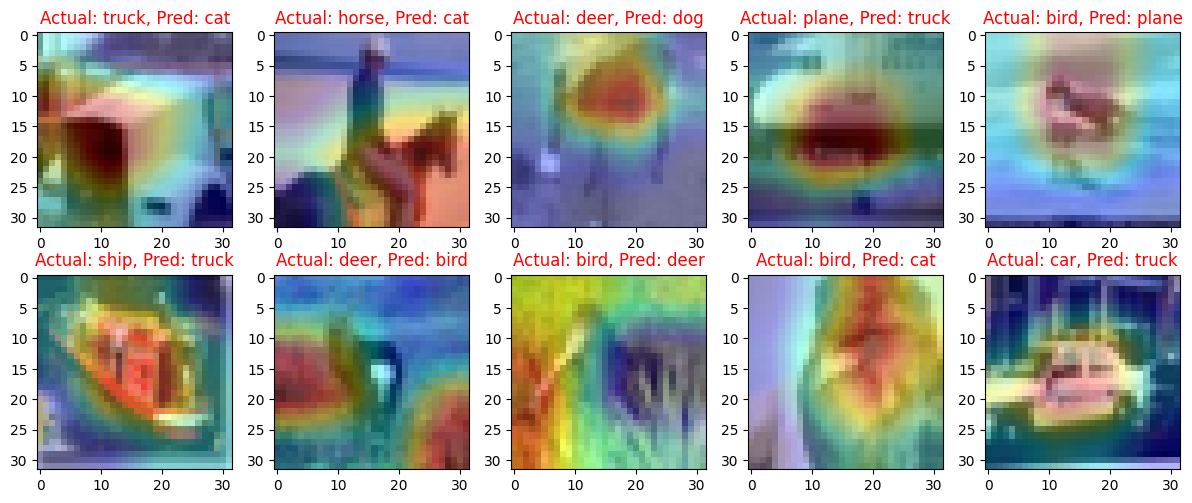

In [ ]:
#get it done for bunch of images,
def plot_grad_cam_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()
    target_layers = [model.layer4[-1]]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    misclassified_images = []
    actual_labels = []
    actual_targets = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    actual_targets.append(target[i])
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        input_tensor = misclassified_images[i].unsqueeze(dim=0)
        targets = [ClassifierOutputTarget(actual_targets[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]

        img = input_tensor.squeeze(0).to('cpu').numpy()
        img = np.transpose(img, (1, 2, 0))  # Convert to numpy and reshape to HxWxC
        img = std * img + mean
        img = np.clip(img, 0, 1)

        visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, image_weight=0.7)

        # npimg = unnormalize(misclassified_images[i].cpu())
        # plt.imshow(npimg, cmap='gray', interpolation='none')

        # npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(visualization)
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()
plot_grad_cam_images(model, test_loader, classes, device)


# Testing

In [ ]:
#originally, main_function
def train(model, device= device, train_loader= train_loader, optimizer= optimizer, scheduler= scheduler, criterion= criterion): #adding scheduler and criterion
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)
        lrs.append(get_lr(optimizer))                           #adding extra line

        # Backpropagation
        loss.backward()
        optimizer.step()
        # scheduler.step()                                        #adding extra line

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

                                                        #adding get_lr function below
        pbar.set_description(desc= f'Loss={loss.item()} LR={get_lr(optimizer)} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    return train_acc, train_losses

#original
def test(model= net, device= device, test_loader= test_loader, criterion= criterion):            #added criterion here
    model = model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            # pred = output.argmax(dim=1, keepdim = True)  # Remove keepdim=True; now shape: [batch_size]
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum().item()        #modified this line


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_acc, test_losses

In [ ]:
!git clone 'https://github.com/shilpiprd/ERA-Solution.git'
%cd ERA-Solution/Sess11\ Solution/

Cloning into 'ERA-Solution'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 188 (delta 70), reused 163 (delta 45), pack-reused 0
Receiving objects: 100% (188/188), 33.77 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/ERA-Solution/Sess11 Solution


In [ ]:
from models.resnet import ResNet18
# from dataloader import train_loader, test_loader
import torch

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18()
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

100%|██████████| 170498071/170498071 [00:03<00:00, 42953821.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


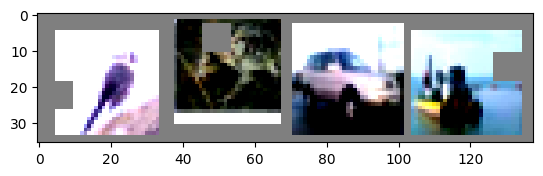

bird  frog  car   ship 


In [ ]:
#wanna visualize ur data ?
from my_main import visualize_train_data
visualize_train_data()

In [ ]:
!pip install torch_lr_finder
!pip install ttach

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.81E-03


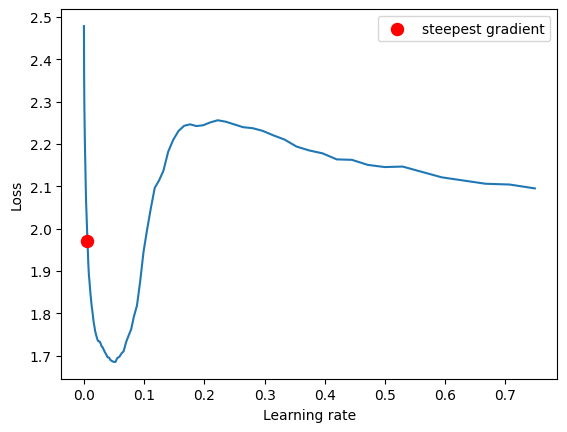

In [ ]:
#adding new code
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_lr_finder import LRFinder
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
#importing train_loader from one
from my_main import train_loader, train, test, classes

# criterion = nn.CrossEntropyLoss()
# my_optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# lr_finder = LRFinder(model, my_optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # this should give u the lr to feed in OneCyclePolicy
net_exp = copy.deepcopy(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp.parameters(), lr = 1e-3 , momentum = 0.85)
lr_finder = LRFinder(net_exp, optimizer, criterion, device = "cuda")
lr_finder.range_test(train_loader, start_lr=1e-5, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr = False)
lr_finder.reset()

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
EPOCHS = 24
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr= 5.81E-03, #set this value
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=0.2,
                                                three_phase=False, #adding this on my own
                                                final_div_factor=100, #adding this on my own
                                                anneal_strategy='linear')


In [ ]:
from my_main import train, test
from my_main import test_loader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from my_main import test
EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH: ", epoch)
    train_acc, train_loss = train(model, device, train_loader, optimizer, scheduler, criterion)
    test_acc, test_loss, miscassified = test(model, device, test_loader, criterion)

EPOCH:  0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.8491806983947754 LR=0.0002324 Batch_id=97 Accuracy=20.93: 100%|██████████| 98/98 [00:37<00:00,  2.61it/s]



Test set: Average loss: 0.0037, Accuracy: 3097/10000 (30.97%)

EPOCH:  1


Loss=1.6772346496582031 LR=0.0002324 Batch_id=97 Accuracy=34.37: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0032, Accuracy: 4071/10000 (40.71%)

EPOCH:  2


Loss=1.5180326700210571 LR=0.0002324 Batch_id=97 Accuracy=41.07: 100%|██████████| 98/98 [00:37<00:00,  2.61it/s]



Test set: Average loss: 0.0030, Accuracy: 4375/10000 (43.75%)

EPOCH:  3


Loss=1.454981803894043 LR=0.0002324 Batch_id=97 Accuracy=44.74: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0028, Accuracy: 4811/10000 (48.11%)

EPOCH:  4


Loss=1.3252469301223755 LR=0.0002324 Batch_id=97 Accuracy=47.53: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0027, Accuracy: 5085/10000 (50.85%)

EPOCH:  5


Loss=1.3537541627883911 LR=0.0002324 Batch_id=97 Accuracy=50.45: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0026, Accuracy: 5210/10000 (52.10%)

EPOCH:  6


Loss=1.3541522026062012 LR=0.0002324 Batch_id=97 Accuracy=53.02: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]



Test set: Average loss: 0.0025, Accuracy: 5425/10000 (54.25%)

EPOCH:  7


Loss=1.248974323272705 LR=0.0002324 Batch_id=97 Accuracy=54.92: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]



Test set: Average loss: 0.0024, Accuracy: 5690/10000 (56.90%)

EPOCH:  8


Loss=1.2056959867477417 LR=0.0002324 Batch_id=97 Accuracy=57.18: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0024, Accuracy: 5679/10000 (56.79%)

EPOCH:  9


Loss=1.2311331033706665 LR=0.0002324 Batch_id=97 Accuracy=58.78: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0024, Accuracy: 5731/10000 (57.31%)

EPOCH:  10


Loss=0.9832037687301636 LR=0.0002324 Batch_id=97 Accuracy=60.55: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0021, Accuracy: 6212/10000 (62.12%)

EPOCH:  11


Loss=1.1273847818374634 LR=0.0002324 Batch_id=97 Accuracy=61.56: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]



Test set: Average loss: 0.0021, Accuracy: 6199/10000 (61.99%)

EPOCH:  12


Loss=0.9606850743293762 LR=0.0002324 Batch_id=97 Accuracy=63.13: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0020, Accuracy: 6336/10000 (63.36%)

EPOCH:  13


Loss=1.0482614040374756 LR=0.0002324 Batch_id=97 Accuracy=64.14: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0020, Accuracy: 6362/10000 (63.62%)

EPOCH:  14


Loss=0.9409760236740112 LR=0.0002324 Batch_id=97 Accuracy=65.69: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0021, Accuracy: 6410/10000 (64.10%)

EPOCH:  15


Loss=0.9721225500106812 LR=0.0002324 Batch_id=97 Accuracy=66.89: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0018, Accuracy: 6829/10000 (68.29%)

EPOCH:  16


Loss=0.90235835313797 LR=0.0002324 Batch_id=97 Accuracy=67.77: 100%|██████████| 98/98 [00:37<00:00,  2.58it/s]



Test set: Average loss: 0.0018, Accuracy: 6828/10000 (68.28%)

EPOCH:  17


Loss=0.9495681524276733 LR=0.0002324 Batch_id=97 Accuracy=68.57: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0019, Accuracy: 6683/10000 (66.83%)

EPOCH:  18


Loss=0.8758156895637512 LR=0.0002324 Batch_id=97 Accuracy=69.31: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0018, Accuracy: 6847/10000 (68.47%)

EPOCH:  19


Loss=0.8489177227020264 LR=0.0002324 Batch_id=97 Accuracy=70.21: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0016, Accuracy: 7063/10000 (70.63%)

EPOCH:  20


Loss=0.9225285649299622 LR=0.0002324 Batch_id=97 Accuracy=71.25: 100%|██████████| 98/98 [00:37<00:00,  2.59it/s]



Test set: Average loss: 0.0016, Accuracy: 7163/10000 (71.63%)

EPOCH:  21


Loss=0.7695744037628174 LR=0.0002324 Batch_id=97 Accuracy=71.60: 100%|██████████| 98/98 [00:38<00:00,  2.58it/s]



Test set: Average loss: 0.0016, Accuracy: 7158/10000 (71.58%)

EPOCH:  22


Loss=0.7063165307044983 LR=0.0002324 Batch_id=97 Accuracy=72.45: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0016, Accuracy: 7269/10000 (72.69%)

EPOCH:  23


Loss=0.7151980996131897 LR=0.0002324 Batch_id=97 Accuracy=73.02: 100%|██████████| 98/98 [00:37<00:00,  2.60it/s]



Test set: Average loss: 0.0015, Accuracy: 7277/10000 (72.77%)



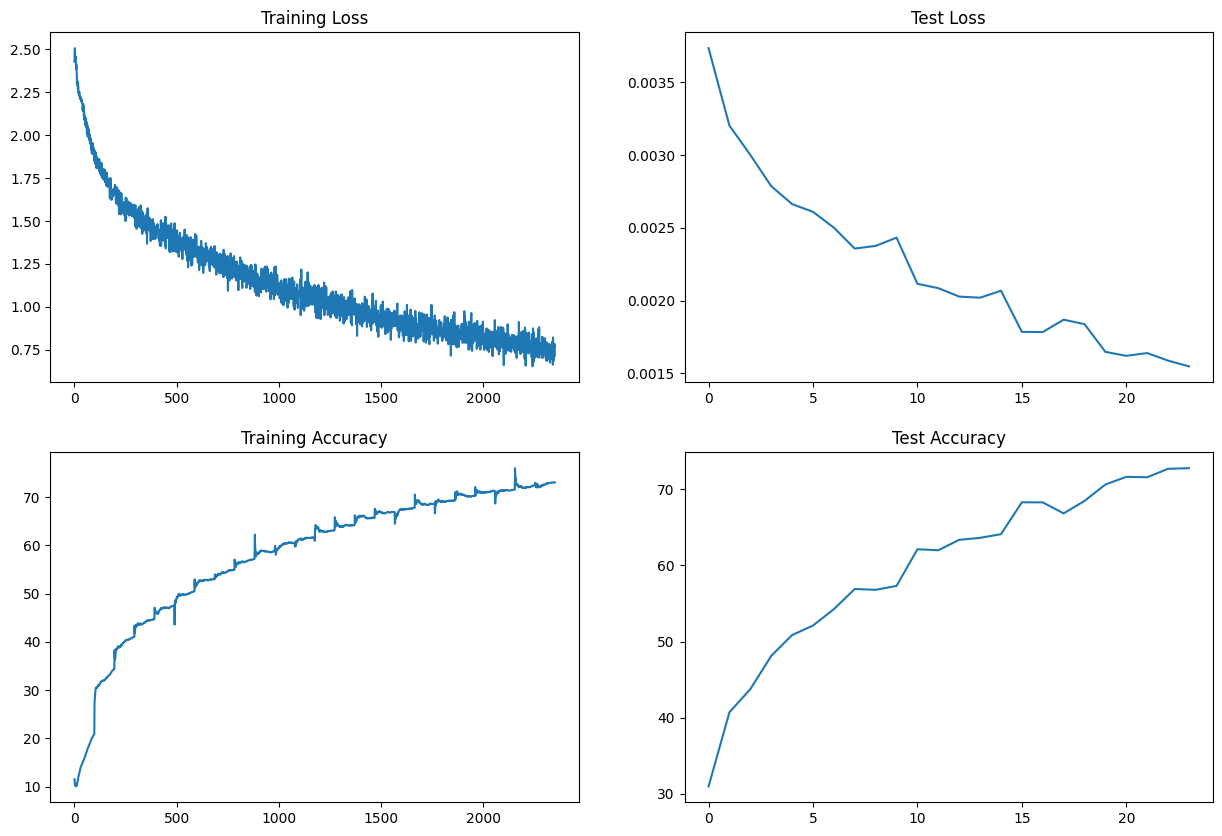

In [ ]:
#visualize the trianing and test loss :
from my_utils import visualize_loss_accuracy
from torchvision import transforms
import math
visualize_loss_accuracy(train_loss,train_acc, test_loss, test_acc)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


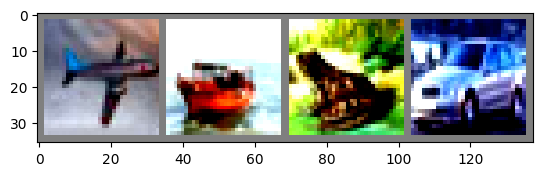

plane ship  frog  car  


In [ ]:
#display an image from test set
# images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from my_main import test_loader

def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(test_loader)
images, labels = next(dataiter)
# images,labels = images.to(device),labels.to(device)
imshow(torchvision.utils.make_grid(images[:4])) #deciding to take 4 pictures
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

torch.Size([512, 3, 32, 32])


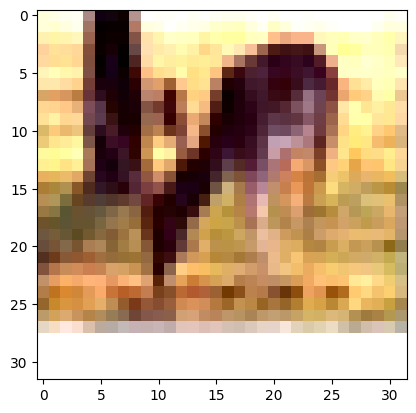

tensor([4], device='cuda:0')
deer


In [ ]:
#if images is a list of all images ,
print(images.shape)
imshow(images[4])
label_pred = model(images[4].unsqueeze(0).to(device))
label_idx = torch.argmax(label_pred, dim=1)
print(label_idx)
print(classes[label_idx])

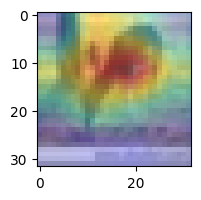

In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

idx = 4 #choosing the 4th image from test dataset, and applying cam on it
target_layers = [model.layer4[-1]]
input_tensor = images[idx].unsqueeze(dim=0)# Create an input tensor image for your model..
cam = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(labels[idx])]
targets = None
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

img = input_tensor.squeeze(0).to('cpu').numpy()
img = np.transpose(img, (1, 2, 0))  # Convert to numpy and reshape to HxWxC
img = std * img + mean
img = np.clip(img, 0, 1)

visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, image_weight=0.7)

fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(visualization)

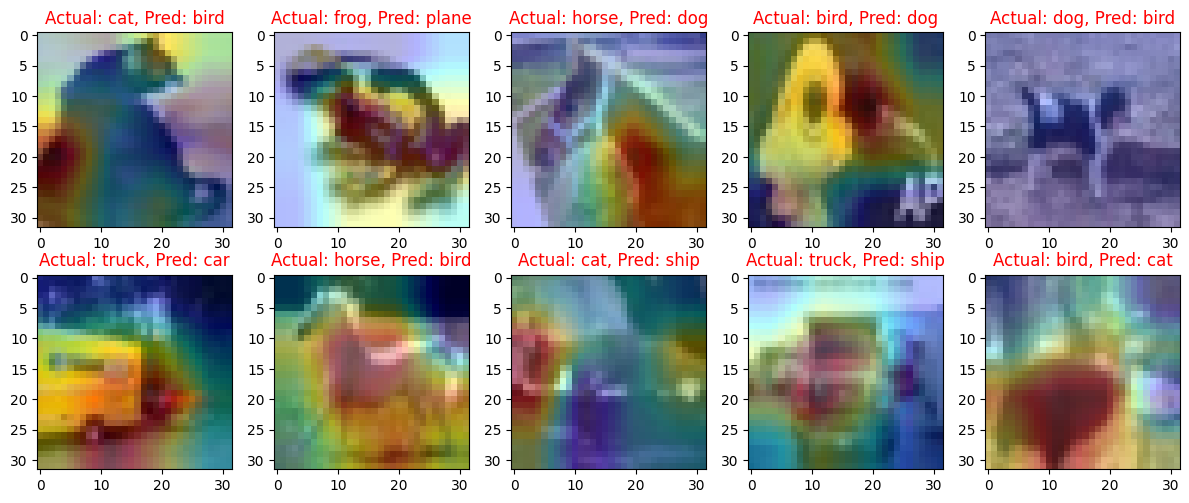

In [ ]:
#get it done for bunch of images,
def plot_grad_cam_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()
    target_layers = [model.layer4[-1]]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    misclassified_images = []
    actual_labels = []
    actual_targets = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    actual_targets.append(target[i])
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        input_tensor = misclassified_images[i].unsqueeze(dim=0)
        targets = [ClassifierOutputTarget(actual_targets[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]

        img = input_tensor.squeeze(0).to('cpu').numpy()
        img = np.transpose(img, (1, 2, 0))  # Convert to numpy and reshape to HxWxC
        img = std * img + mean
        img = np.clip(img, 0, 1)

        visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, image_weight=0.7)
        plt.imshow(visualization)
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()
plot_grad_cam_images(model, test_loader, classes, device)
